# BMM using scikit learn 

## Author: Jordan Melendez, Alexandra Semposki

### Date last edited: 18 March 2024

In this notebook, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from utils import *
from scripts import *

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.16

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively.

In [2]:
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')

print(data_xeft.files)

['density', 'dens_scaled', 'mean', 'std_dev', 'cov']


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [3]:
# call training function to obtain desired data
cutoff = 40
training_data = gp_data(data_xeft, data_pqcd, cutoff)

# save this to a file for later use
np.savez('../data/eos_data/correlated_training_data_40n0.npz', density=training_data['dens'], \
         dens_log=np.log(training_data['dens']), mean=training_data['mean'], \
         std=training_data['std'], cov=training_data['cov'])

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.0, 900)[:-1]

(4,) (4,) (4,) (4, 4)
[0.80351171 1.16722408 1.53093645 1.89464883]
[0.12856187 0.18675585 0.24494983 0.30314381]
(4,) (4,) (4,) (4, 4)
(4,) (4,) (4,) (4, 4)
[40.08764608 56.72996661 73.37228715 90.01460768]
Cov shape: (8, 8)


In [28]:
# print out the values
data_20n0 = np.load('../data/eos_data/correlated_training_data_20n0.npz')
data_30n0 = np.load('../data/eos_data/correlated_training_data_30n0.npz')
data_40n0 = np.load('../data/eos_data/correlated_training_data_40n0.npz')

print(data_40n0['std'])

[0.00699455 0.0155712  0.02816155 0.04524719 0.0139346  0.01136025
 0.00987942 0.00889552]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [4]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [5]:
# chiral EFT data for plotting
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean'][:, -1]
p_stdv_xeft = data_xeft['std_dev'][:, -1]
p_cov_xeft = data_xeft['cov'][..., -1]

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD plotting
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

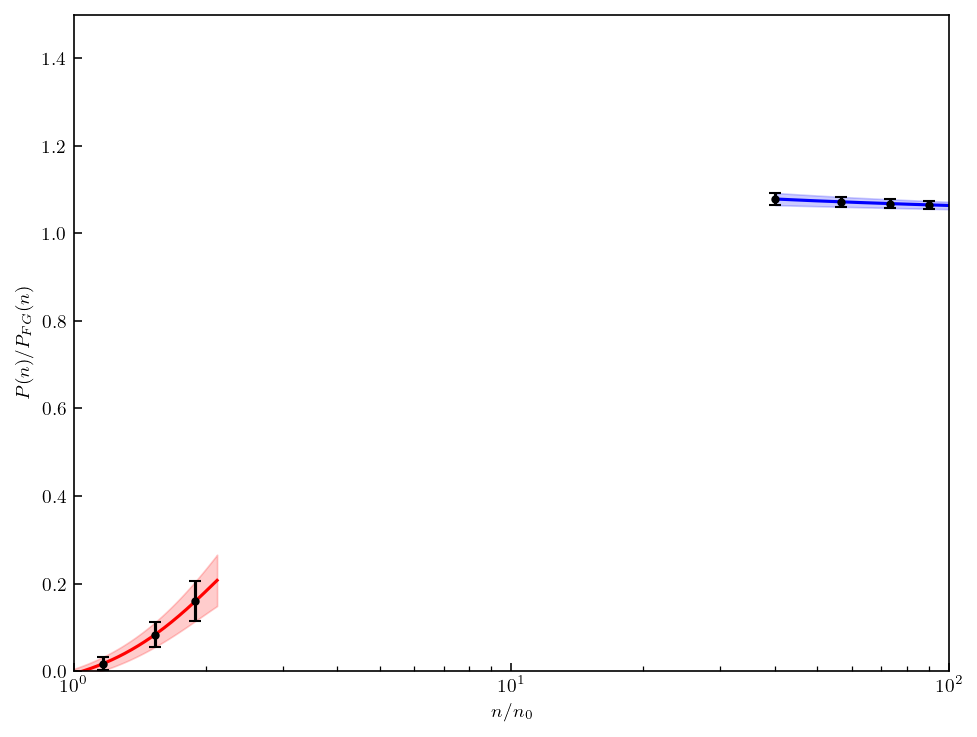

In [6]:
fig, ax = plt.subplots(dpi=150)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
ax.plot(n_xeft/n0, p_mean_xeft, color='red')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the Gaussian Process Regressor function that ties to `sklearn`, and fit to the training data we selected.

In [7]:
kernel = C(constant_value=0.6) * RBF(length_scale=2.0)

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov']  # here is where we input the full covariance matrix from the data
)

gp.fit(X_train, y_train)  # fit to the data we selected from chiral EFT & pQCD

GaussianProcessRegressor2dNoise(alpha=array([[4.89236784e-05, 9.94740841e-05, 1.45739383e-04, 1.75529131e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.94740841e-05, 2.42462189e-04, 4.12792839e-04, 5.70703346e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45739383e-04, 4.12792839e-04, 7.93072739e-04, 1.21844588e-03,...
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.58282325e-04, 1.29055253e-04, 1.12226275e-04, 1.01036999e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.37619883e-04, 1.12226275e-04, 9.76029926e-05, 8.78795420e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.23883368e-04, 1.01036999e-04, 8.78795420e-05, 7.91303122e-05]]),
                                kernel=0.775**2 * RBF(length_scale=2))

We can print out the kernel hyperparameters below, and see what we get using this kernel.

In [8]:
print(gp.kernel_)

0.602**2 * RBF(length_scale=1.85)


We then use the same kernel to predict at new points in density, and plot our GP result, along with the heavy ion collision contour and the FRG EOS contour.

In [9]:
# conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [10]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)

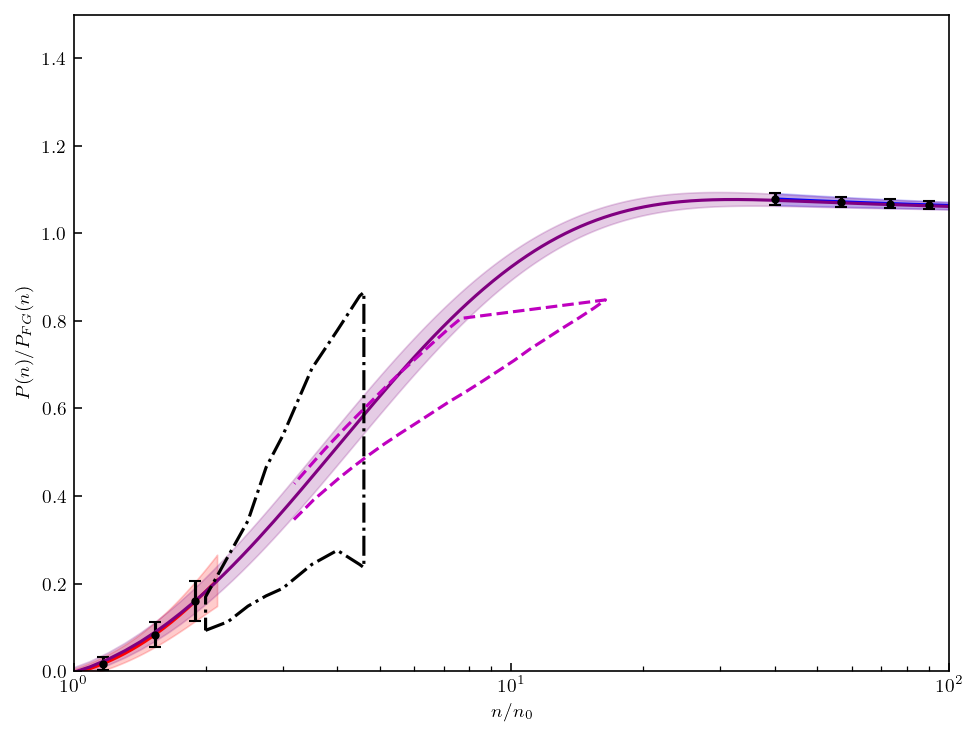

In [11]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred, c='purple')
ax.fill_between(density_test/n0, y_pred-y_stdv, y_pred+y_stdv, color="purple", alpha=0.2)

# import contours and plot
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# unscale FRG
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

plt.show()

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(min(n))}{min(n)} \right],
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this will be the way to best propagate the uncertainties from the pressure to the speed of sound.

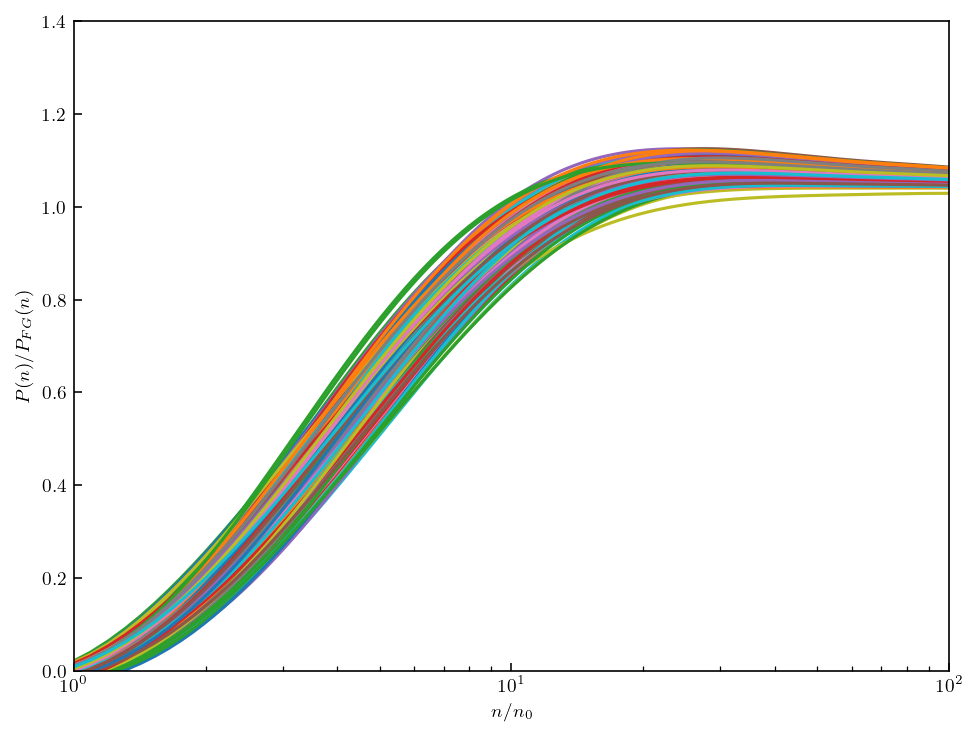

In [12]:
# sample from the pressure GP curve first
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=500)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

(899,)


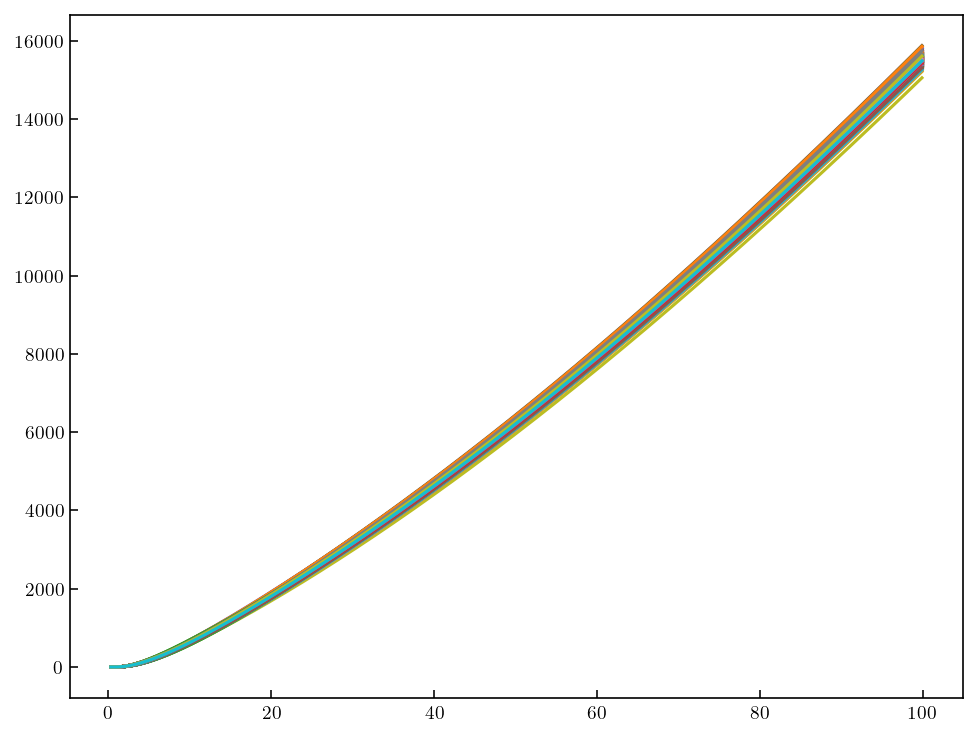

(893, 500)
(893, 500)
At 100*n0, the value of the energy density is:  47637.52750259489


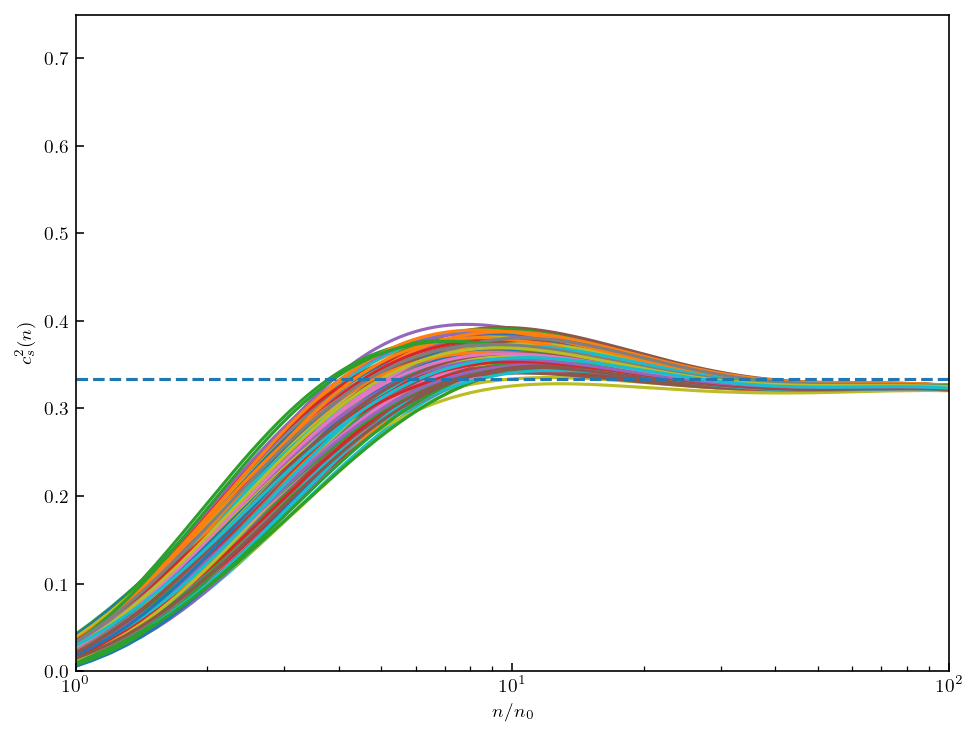

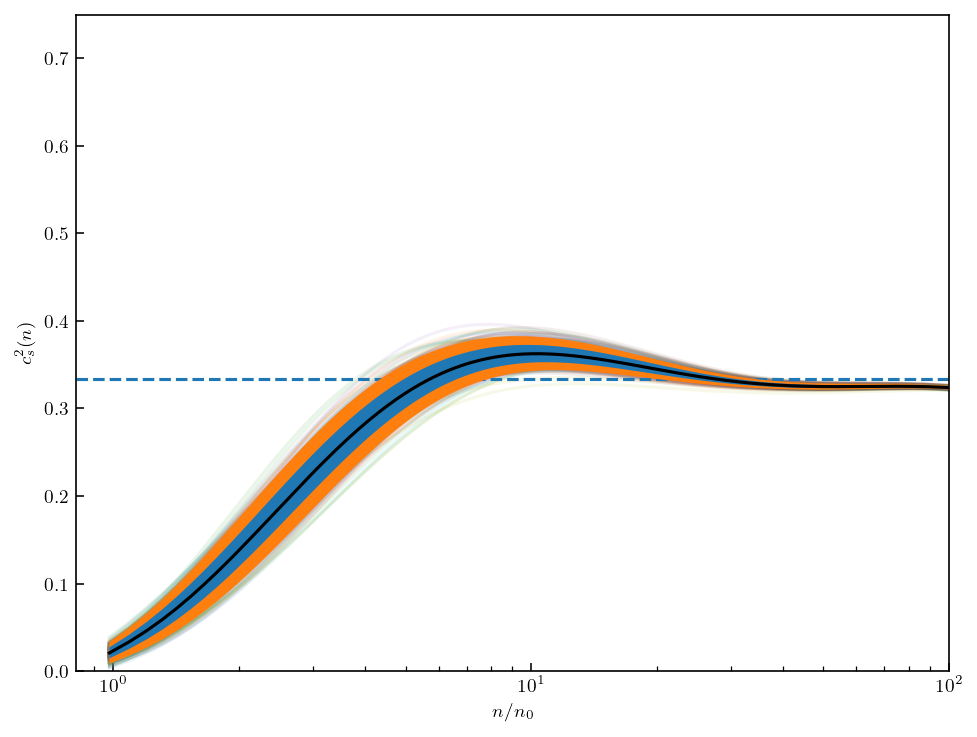

In [13]:
# integrate backward to anchor at pQCD and plot the speed of sound result
pres_samples = samples_data

# run interpolation for FG scaling
gp_cs2_convert_arr = convert_interp(density_test)
print(gp_cs2_convert_arr.shape)

# unscale the samples from the FG scaling
pres_samples_unscaled = [pres_samples[:,i]*gp_cs2_convert_arr \
                         for i in range(len(np.asarray(pres_samples).T))]

# test result
plt.plot(density_test/n0, np.asarray(pres_samples_unscaled).T)
plt.show()

# cut at saturation (or thereabouts)
sat_cut = (np.where([i >= 0.16 for i in density_test])[0][0]) - 1

# pull dict values out and make arrays
gp_mean = y_pred
gp_std = y_stdv

# send to the speed of sound calculation (for interpolation)
pres_dict = {
    'mean': gp_mean[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'std_dev': gp_std[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'samples': np.asarray(pres_samples_unscaled)[:, sat_cut:].T
}

# integrating backwards (mean for now only)
en_0 = 47637.52750259489        #edens_interp(density[1])  # BC at 100*n0
en_0_lower = 47505.507238020364 #en_0 - edens_interp_std(density[1])
en_0_upper = 47769.54772653198

edens_dict = {
    'mean': en_0,  # 175 for n0 gives me something good for pQCD
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function
cs2_log, edens_full = speed_of_sound(density_test[sat_cut:], pres_dict, edens_dict, sat=False, sampled=True)
dens_arr, _, cs2_old, edens_int, _ = speed_of_sound(density_test[sat_cut:], pres_dict, \
                                                       edens_dict, sat=False, integrate='backward')

# dict entries
cs2_log_mean = cs2_log['mean']
cs2_log_std = cs2_log['std']
cs2_log_samples = cs2_log['samples']

# print number at edge
print('At 100*n0, the value of the energy density is: ', np.asarray(edens_int['mean'])[-1])

# samples plot
[plt.plot(density_test[sat_cut:]/n0, cs2_log_samples[i]) for i in range(len(edens_full))]
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.16/n0, 16.0/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# mean and std dev band plot
[plt.plot(density_test[sat_cut:]/n0, cs2_log_samples[i], alpha=0.1) for i in range(len(edens_full))]
plt.plot(density_test[sat_cut:]/n0, cs2_log_mean, 'k', zorder=20)
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_log_mean-cs2_log_std, cs2_log_mean+cs2_log_std, zorder=12)
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_log_mean-1.96*cs2_log_std, cs2_log_mean+1.96*cs2_log_std, zorder=10)
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.13/n0, 16.0/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

Excellent! Now we have our samples, so we can plot the results for $P(n)$ and $c_{s}^{2}(n)$ side-by-side like in Sec. IV of our paper. First we will import the speed of sound data from the $\chi$EFT and pQCD results.

In [14]:
# import the data
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')

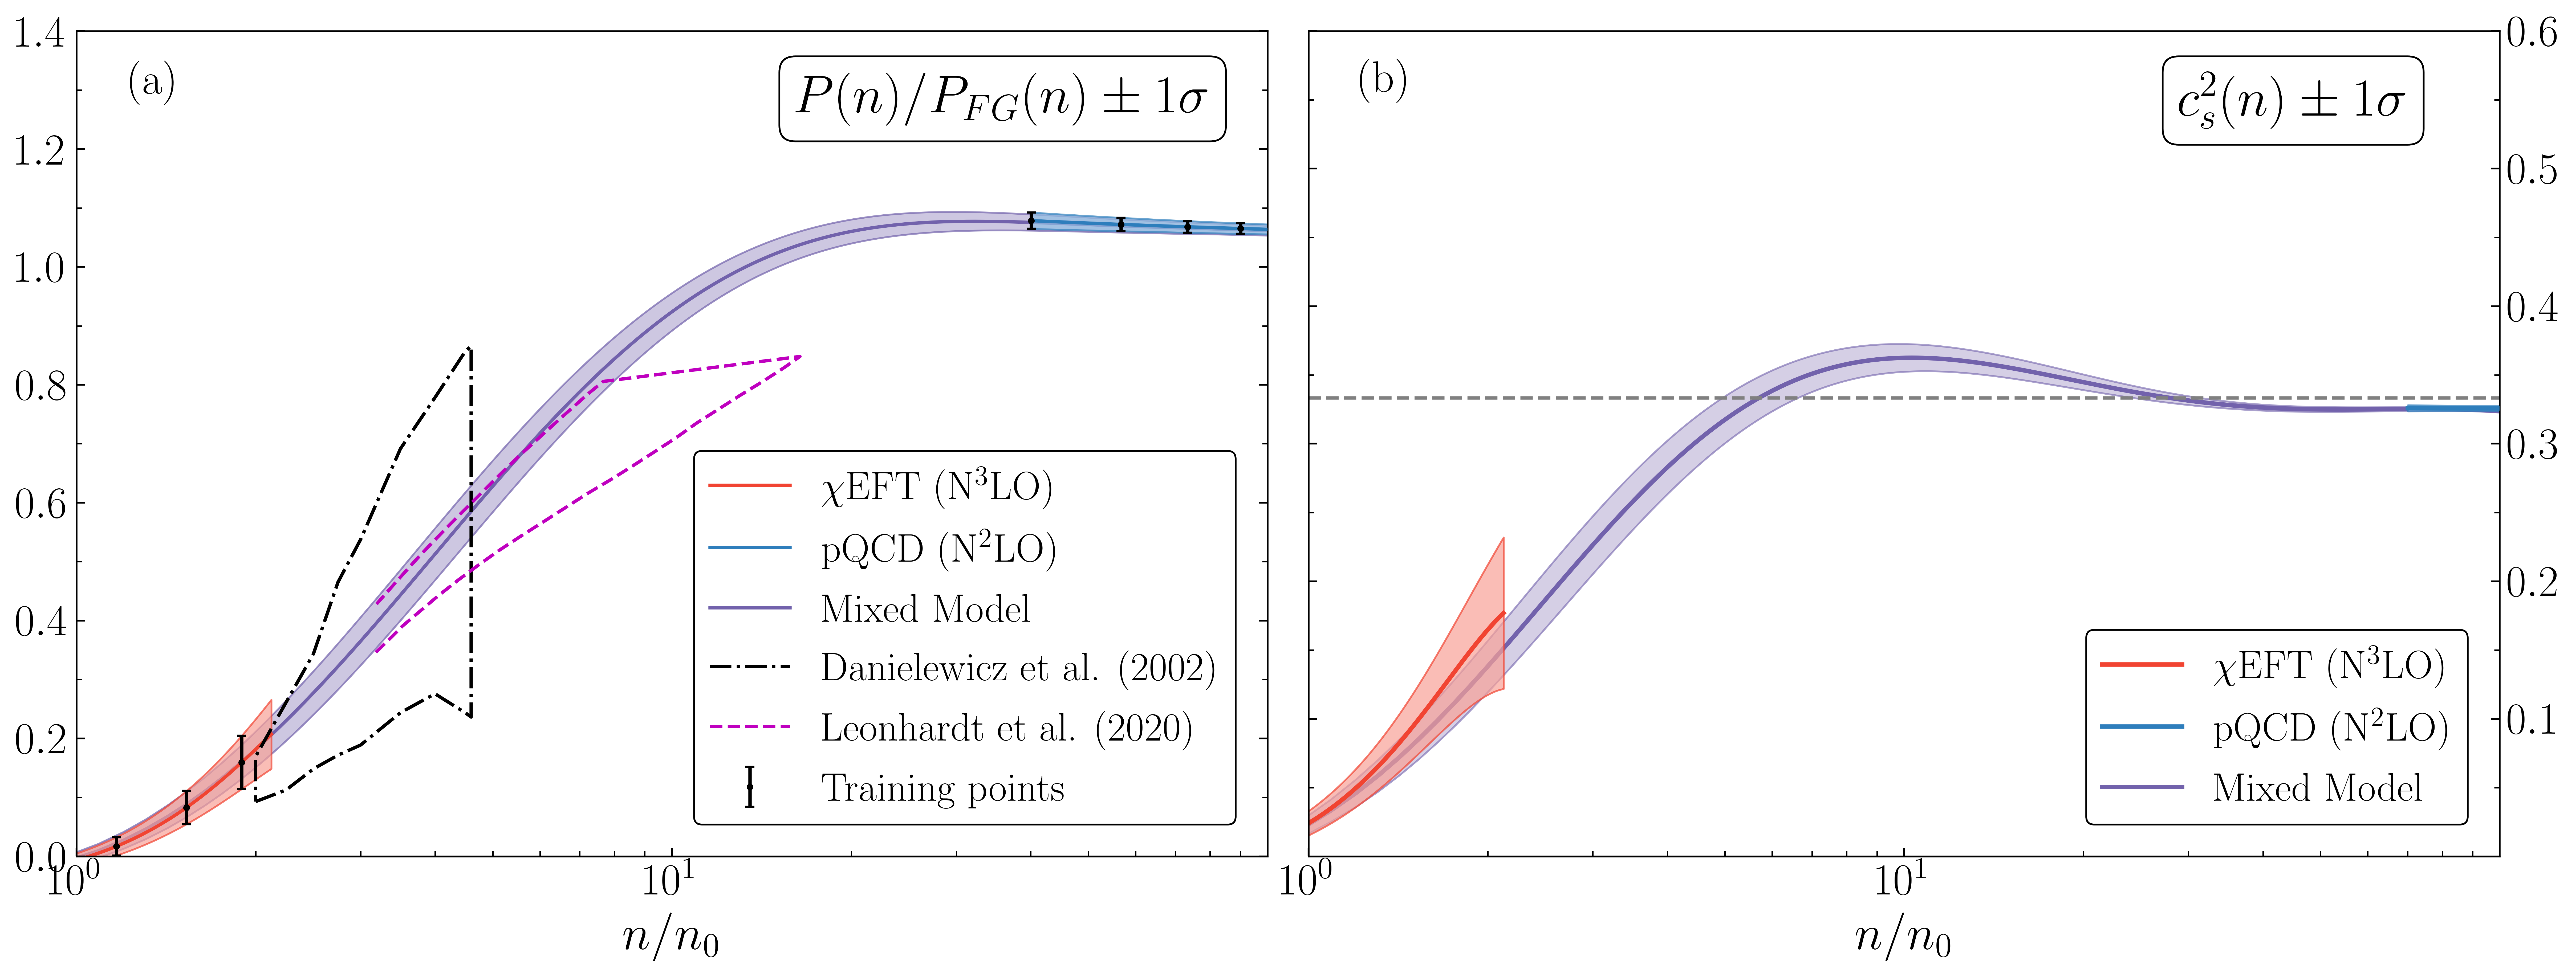

In [15]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density_test/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density_test/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean'][:,2]
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0].fill_between(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - \
                   1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:], zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0].fill_between(density_test/n0, gp_mean-1.0*gp_std, gp_mean+ \
                   1.0*gp_std,
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density_test/n0, gp_mean, color=colors[2], zorder=-1, label='Mixed Model')
  
# plot FRG and HIC contours
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0].errorbar(training_data["dens"]/n0, training_data["mean"], yerr=training_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test[sat_cut:]/n0, cs2_log_mean-cs2_log_std, cs2_log_mean+cs2_log_std,\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test[sat_cut:]/n0, cs2_log['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
fig.savefig('subplot_curvewise_model_40n0.PNG', bbox_inches='tight')

Alexandra Semposki, 18 March 2024.